In [ ]:
# default_exp modeling.seq2seq.summarization

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# modeling.seq2seq.summarization

> This module contains custom models, custom splitters, etc... summarization tasks.

In [ ]:
#export
import torch
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import get_blurr_tfm
from blurr.data.seq2seq.core import *
from blurr.data.seq2seq.summarization import *
from blurr.modeling.core import *
from blurr.modeling.seq2seq.core import *

logging.set_verbosity_error()

[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1+cu110
Using fastai 2.2.5
Using transformers 4.2.1


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Summarization

The objective of summarization is to generate a concise and accurate representation of a much larger body of text.  For example, we may want to summarize an article in a single sentence.

### Prepare the data

In [ ]:
path = Path('./')
cnndm_df = pd.read_csv(path/'cnndm_sample.csv'); len(cnndm_df)

1000

In [ ]:
cnndm_df.head(2)

,article,highlights,ds_type
0,"(CNN) -- Globalization washes like a flood over the world's cultures and economies. Floods can be destructive; however, they can also bring blessings, as the annual floods of the Nile did for ancient Egypt. The world's great universities can be crucial instruments in shaping, in a positive way, humankind's reaction to globalization and the development of humankind itself. Traditionally, universities have been defined and limited by location, creating an academic community and drawing students and scholars to that place. Eventually, some universities began to encourage students to study el...","John Sexton: Traditionally, universities have been defined and limited by location .\nGlobal campuses form a network of thought, innovation, he writes .\nFaculty can teach, Sexton says, students can team up in many cities at once .\nSexton: Research, scholarship can be shared and cultural ties made in ""century of knowledge""",train
1,"(CNN) -- Armenian President Robert Kocharian declared a state of emergency Saturday night after a day of clashes between police and protesters, a spokeswoman for the Armenian Foreign Ministry said. Opposition supporters wave an Armenian flag during a protest rally in Yerevan, Armenia, on Saturday. The protesters claim last month's presidential election was rigged. The state of emergency will ""hopefully bring some order"" to the capital, Yerevan, said Salpi Ghazarian, assistant to the Armenian foreign minister, who spoke to CNN early Sunday. The state of emergency could last until March 20, ...","NEW: Protest moves after crackdown at Freedom Square .\nOrder sought after protests over last month's election turn violent .\nDemonstrators say the election was fraudulent .\nState of emergency could last until March 20, official says .",train


In [ ]:
#hide

# pretrained_model_name = "t5-small"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
#                                                                                model_cls=T5ForConditionalGeneration)

# pretrained_model_name = "google/pegasus-cnn_dailymail"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
#                                                                                model_cls=PegasusForConditionalGeneration)

# pretrained_model_name = "facebook/bart-large-cnn"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
#                                                                                model_cls=BartForConditionalGeneration)


In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
text_gen_kwargs = {}
if (hf_arch in ['bart', 't5']):
    text_gen_kwargs = {**hf_config.task_specific_params['summarization'], **{'max_length': 30, 'min_length': 10}}

# not all "summarization" parameters are for the model.generate method ... remove them here
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs.copy():
    if k not in generate_func_args: del text_gen_kwargs[k]

if (hf_arch == 'mbart'):
    text_gen_kwargs['decoder_start_token_id'] = hf_tokenizer.get_vocab()["en_XX"]

In [ ]:
tok_kwargs = {}
if (hf_arch == 'mbart'):
    tok_kwargs['src_lang'], tok_kwargs['tgt_lang'] = "en_XX", "en_XX"

In [ ]:
before_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                                  max_length=256, max_target_length=130,
                                                  tok_kwargs=tok_kwargs, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=before_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(cnndm_df, bs=2)

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 77]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"(CNN) -- Home to up to 10 percent of all known species, Mexico is recognized as one of the most biodiverse regions on the planet. The twin threats of climate change and human encroachment on natural environments are, however, threatening the existence of the country's rich wildlife. And there is a great deal to lose. In the United Nations Environment Program (UNEP) World Conservation Monitoring Centre's list of megadiverse countries Mexico ranks 11th. The list represents a group of 17 countries that harbor the majority of the Earth's species and are therefore considered extremely biodiverse. From its coral reefs in the Caribbean Sea to its tropical jungles in Chiapas and the Yucatan peninsula and its deserts and prairies in the north, Mexico boasts an incredibly rich variety of flora and fauna. Some 574 out of 717 reptile species found in Mexico -- the most in any country -- can only be encountered within its borders. It is home to 502 types of mammals, 290 species of birds, 1,150 varieties of birds and 26,000 classifications of plants. Pronatura, a non-profit organization that works to promote conservation and sustainable development in Mexico, has selected six species which it says symbolize the problems faced by the","Mexico hosts to up to 10 percent of all known species on Earth.\nIt is home to 502 types of mammals, 290 bird species and 26,000 types of plants.\nHuman development and climate change is placing a big strain on its biodiversity.\nThe Golden Eagle is under threat in spite of being the country's national symbol."
1,"Dan Condon believes in recycling. Just not when it comes to his hotel towels. Condon composts when he's at home in Boulder, Colorado. He eats local, organic and fair-trade food and drives a Honda CR-Z hybrid sports car. You might call him green. Except he's not so green when he travels for his work at an education nonprofit and stays in a hotel, which happens about 10 weeks per year. There, he uses a new towel every day. And don't try to bribe him with a drink or dessert coupon to get him to reuse the same one. ""I could care less about rewards for environmentally conscious behavior unless it's miles,"" Condon wrote in an e-mail. If hotels can't convince a hybrid-driving recycling enthusiast like Condon to go green while traveling, how can they possibly convince everyone else? 9 glamorous movie-star hotels. That's the problem of hotels trying to ""green"" your hotel stay. After guests have paid a pretty penny for a night at the inn, even the most environmental guests may want to treat themselves to fresh towels every day and those little bottles of sweet-smelling shampoo. Despite the fact that most people describe themselves in surveys as environmentally conscious and as preferring green products,","Hotel guests who ""go green"" are happier with their stay.\nIncreasing water and energy costs are pushing hotels to cut costs wherever they can.\nMany hotels find that guests don't mind using the same towels and sheets every night.\nTripAdvisor will be adding a green label for hotels listed on its site."


### Train model

In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(), #HF_PreCalculatedLoss()
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)) #.to_native_fp16() #.to_fp16()

learn.create_opt() 
learn.freeze()

In [ ]:
# learn.blurr_summary()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds),preds['loss'].shape, preds['logits'].shape

(4, torch.Size([]), torch.Size([2, 69, 50264]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([2, 256]), 2, torch.Size([2, 69]))

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=1.4454397387453355e-05)

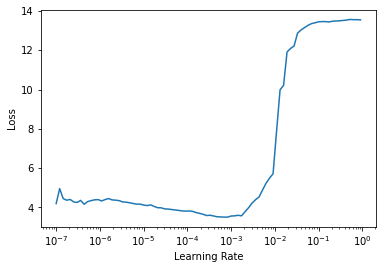

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=4e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.755243,1.677269,0.321931,0.148253,0.253911,0.893918,0.866098,0.879660,02:18


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"London (CNN) -- In 1948, a hospital outside London witnessed the birth of the Paralympic movement, as a Jewish doctor who had fled Nazi Germany sought to change the lives of patients with spinal injuries -- and inspire new hope in them through sport. The first ""Stoke Mandeville Games"" were organized in 1948 to coincide with the London Olympics, the second to be held in Britain. Named for the hospital in Buckinghamshire where Prof. Ludwig Guttmann's pioneering spinal injuries unit was based, the","Paralympic movement was born in Stoke Mandeville, outside London, in 1948.\n2012 Games will be the biggest yet, with 4,200 competitors from 165 countries.\nIn an echo of the first, post-World War II Games, injured veterans are among the athletes.\nThey",Paralympic Games began in 1948 at Stoke Mandeville hospital outside London .\nThe first Games were organized to coincide with
1,"Police missed speaking with suspected Los Angeles International Airport shooter Paul Ciancia by ""a matter of minutes"" the day his family asked authorities to check on him after receiving disturbing messages, according to the chairman of the House Homeland Security Committee. By the time officers arrived at Ciancia's apartment Friday, he had already left -- as little as 45 minutes earlier -- for the airport, according to U.S. Rep. Michael McCaul. As authorities piece together Ciancia's actions l","Paul Ciancia began asking for a ride to the airport days before the shooting.\nPolice performing a welfare check at his family's request missed him by less than an hour.\nCongressman calls the timing ""tragic""\nThe suspect is ""unresponsive"" and cannot s",Suspect Paul Ciancia's family asked authorities to check on him after disturbing messages .\nBy the time police arrived at his


In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""

In [ ]:
outputs = learn.blurr_generate(test_article, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Gunmen with pistols and machine guns rob Swiss casino, police say .
They make off with several hundred thousand Swiss francs in the early hours of Sunday morning .
There were no serious injuries, although one guest was kicked in the head by one of the robbers .
The robbers spoke French and drove vehicles with French lRicense plates .
Swiss authorities are working closely with French authorities .

=== Prediction 2 ===
 Gunmen with pistols and machine guns rob Swiss casino, police say .
They make off with several hundred thousand Swiss francs in the early hours of Sunday morning .
There were no serious injuries, but one guest was kicked in the head by one of the robbers .
The robbers spoke French and drove vehicles with French lRicense plates .
Swiss authorities are working closely with French authorities .

=== Prediction 3 ===
 Gunmen with pistols and machine guns rob Swiss casino, police say .
They make off with several hundred thousand Swiss francs in the early

### Inference

In [ ]:
export_fname = 'summarize_export'

In [ ]:
learn.metrics = None
learn.export(fname=f'{export_fname}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_generate(test_article)

[' Gunmen with pistols and machine guns rob Swiss casino, police say .\nThey make off with several hundred thousand Swiss francs']

## Tests

The purpose of the following tests is to ensure as much as possible, that the core training code works for the pretrained **summarization models** below.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained summarization models you are working with ... and if any of your pretrained summarization models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
[ model_type for model_type in BLURR_MODEL_HELPER.get_models(task='ConditionalGeneration') 
 if (not model_type.__name__.startswith('TF')) ]

[transformers.models.bart.modeling_bart.BartForConditionalGeneration,
 transformers.models.blenderbot.modeling_blenderbot.BlenderbotForConditionalGeneration,
 transformers.models.blenderbot_small.modeling_blenderbot_small.BlenderbotSmallForConditionalGeneration,
 transformers.models.fsmt.modeling_fsmt.FSMTForConditionalGeneration,
 transformers.models.led.modeling_led.LEDForConditionalGeneration,
 transformers.models.mbart.modeling_mbart.MBartForConditionalGeneration,
 transformers.models.mt5.modeling_mt5.MT5ForConditionalGeneration,
 transformers.models.pegasus.modeling_pegasus.PegasusForConditionalGeneration,
 transformers.models.prophetnet.modeling_prophetnet.ProphetNetForConditionalGeneration,
 transformers.models.t5.modeling_t5.T5ForConditionalGeneration,
 transformers.models.xlm_prophetnet.modeling_xlm_prophetnet.XLMProphetNetForConditionalGeneration]

In [ ]:
pretrained_model_names = [
    'facebook/bart-base',
    #'facebook/blenderbot_small-90M',
    'allenai/led-base-16384',
    'sshleifer/tiny-mbart',
    'google/mt5-small',
    'sshleifer/distill-pegasus-cnn-16-4',
    't5-small', 
    #'microsoft/prophetnet-large-uncased',
    #'microsoft/xprophetnet-large-wiki100-cased', # XLMProphetNet
]

In [ ]:
path = Path('./')
cnndm_df = pd.read_csv(path/'cnndm_sample.csv')

In [ ]:
#slow
#hide_output
task = HF_TASKS_AUTO.Seq2SeqLM
bsz = 2
inp_seq_sz = 64; trg_seq_sz = 40

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(model_name, task=task)
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n')

    # 1. build your DataBlock
    text_gen_kwargs = {}
    if (hf_arch in ['bart', 't5']):
        text_gen_kwargs = {**hf_config.task_specific_params['summarization'], **{'max_length': 30, 'min_length': 10}}
    
    # not all "summarization" parameters are for the model.generate method ... remove them here
    generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
    for k in text_gen_kwargs.copy():
        if k not in generate_func_args: del text_gen_kwargs[k]
            
    if (hf_arch == 'mbart'):
        text_gen_kwargs['decoder_start_token_id'] = hf_tokenizer.get_vocab()["en_XX"]
            
    tok_kwargs = {}
    if (hf_arch == 'mbart'):
        tok_kwargs['src_lang'], tok_kwargs['tgt_lang'] = "en_XX", "en_XX"
            
    def add_t5_prefix(inp): return f'summarize: {inp}' if (hf_arch == 't5') else inp
    
    before_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                      padding='max_length', 
                                                      max_length=inp_seq_sz, 
                                                      max_target_length=trg_seq_sz, 
                                                      tok_kwargs=tok_kwargs, text_gen_kwargs=text_gen_kwargs)
    
    blocks = (HF_Seq2SeqBlock(before_batch_tfm=before_batch_tfm), noop)
    dblock = DataBlock(blocks=blocks, 
                   get_x=Pipeline([ColReader('article'), add_t5_prefix]), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())

    dls = dblock.dataloaders(cnndm_df, bs=bsz) 
    b = dls.one_batch()

    # 2. build your Learner
    seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        }
    }
    
    model = HF_BaseModelWrapper(hf_model)
    learn_cbs = [HF_BaseModelCallback]
    fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]
 
    learn = Learner(dls, 
                    model,
                    opt_func=ranger,
                    loss_func=HF_PreCalculatedLoss(),
                    cbs=learn_cbs,
                    splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

    learn.create_opt() 
    learn.freeze()
    
    # 3. Run your tests
    try:
        print('*** TESTING DataLoaders ***\n')
        test_eq(len(b), 2)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, inp_seq_sz]))
        test_eq(len(b[1]), bsz)

#         print('*** TESTING One pass through the model ***')
#         preds = learn.model(b[0])
#         test_eq(preds[1].shape[0], bsz)
#         test_eq(preds[1].shape[2], hf_config.vocab_size)

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=fit_cbs)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, input_trunc_at=500, target_trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== facebook/bart-base ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,3.649484,3.239390,0.281170,0.102605,0.221654,01:04


,text,target,prediction
0,"(CNN) -- Home to up to 10 percent of all known species, Mexico is recognized as one of the most biodiverse regions on the planet. The twin threats of climate change and human encroachment on natural environments are, however, threatening the existence of the country's rich wildlife. And there is a great","Mexico hosts to up to 10 percent of all known species on Earth.\nIt is home to 502 types of mammals, 290 bird species and 26,000 types of plants.\nHuman development",Mexico is recognized as one of the most biodiverse regions on the planet .\nThe country's climate change and human encroachment on natural
1,"I have an uncle who has always been a robust and healthy guy. He drank a glass of skim milk every day, bragged about how many pull-ups he was doing and fit into pants he was wearing 20 years before. He didn't take a single medication and retired early. Given that he had no",Sanjay Gupta: Moral hazard causes some to neglect health when they get health insurance.\nHe says Obamacare alone won't guarantee good health; personal habits must do that.\nHe says research,"I have an uncle who has always been a robust and healthy guy .\nHe had no medication and retired early, he says .\n"


=== allenai/led-base-16384 ===

architecture:	led
tokenizer:	LEDTokenizerFast
model:		LEDForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,3.121611,3.067819,0.257483,0.089445,0.207749,03:02


,text,target,prediction
0,"Washington (CNN) -- Moments after the U.S. Supreme Court ruled on a pair of same-sex marriage cases, the handful of Democrats considering running for president in 2016 stumbled over themselves in a rush of celebratory reaction, blasting out a salvo of congratulatory press releases and tweets. Rulings","Democrats who support same-sex marriage are now playing on increasingly friendly political turf.\nGOP leaders express dismay at ruling, but seem eager to be rid of a polarizing issue.\nThe",Democrats are in a rush of celebratory reaction .\nDemocrats are considering running for president in
1,"As a growing number of airplanes scoured the southern Indian Ocean in the search for Malaysia Airlines Flight 370, authorities released new details that paint a different picture of what may have happened in the plane's cockpit. Military radar tracking shows that the aircraft changed altitude after making a sharp turn over the South China Sea as it","U.S. Navy sending listening device to help find voice and data recorders if wreckage is found.\nSource: Plane changed altitude, flying as low as 12,000 feet after making",NEW: Malaysia Airlines Flight 370 was found in the South China Sea .\nThe plane changed


=== sshleifer/tiny-mbart ===

architecture:	mbart
tokenizer:	MBartTokenizerFast
model:		MBartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,12.429354,12.428593,0.000000,0.000000,0.000000,00:32


,text,target,prediction
0,"(CNN) -- Two weeks. Two gut-wrenching, frustrating, mysterious weeks. That's how long it's been since 227 passengers and 12 crew members boarded Malaysia Airlines Flight 370, destined for Beijing. A routine trip, it seemed, to catch up",NEW: Planes depart Australia to resume their search for airplane debris. NEW: Official: Passengers' relatives are moved to a different Kuala Lumpur hotel,بیبیبیبیبیبیبیبیبیبیبیبیبیبیبیبیبیبی
1,"(CNN) -- It's a congested, sprawling transport hub surrounded by 1950s architecture and predominantly used by commuters or tourists to cross the city of Istanbul. But proposed changes to Taksim Square have seen it become the flashpoint for protests",Taksim Square was where Istanbul's water was distributed -- Taksim means divide. The site is seen as symbolizing the seclar Turkish republic founded by Ataturk,بیبیبیبیبیبیبیبیبیبیبیبیبیبیبیبیبیبی


=== google/mt5-small ===

architecture:	mt5
tokenizer:	T5TokenizerFast
model:		MT5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,7.112539,5.317055,0.040722,0.003028,0.037818,01:06


,text,target,prediction
0,"Dan Condon believes in recycling. Just not when it comes to his hotel towels. Condon composts when he's at home in Boulder, Colorado. He eats local, organic and fair-trade food and drives a Honda CR-Z hybrid sports car","Hotel guests who ""go green"" are happier with their stay. Increasing water and energy costs are pushing hotels to cut costs wherever they",<extra_id_0> . . <extra_id_10> a a a a a a
1,"London (CNN) -- In 1948, a hospital outside London witnessed the birth of the Paralympic movement, as a Jewish doctor who had fled Nazi Germany sought to change the lives of patients with spinal injuries -- and inspire new hope in them through sport. The first","Paralympic movement was born in Stoke Mandeville, outside London, in 1948. 2012 Games will be the biggest yet, with 4,200 competitors from 165 countries. In",<extra_id_0> - .


=== sshleifer/distill-pegasus-cnn-16-4 ===

architecture:	pegasus
tokenizer:	PegasusTokenizerFast
model:		PegasusForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,3.495460,3.036035,0.309482,0.122699,0.242232,01:50


,text,target,prediction
0,"(CNN) -- Home to up to 10 percent of all known species, Mexico is recognized as one of the most biodiverse regions on the planet. The twin threats of climate change and human encroachment on natural environments are, however, threatening the existence of the country's rich wildlife. And there is a great deal","Mexico hosts to up to 10 percent of all known species on Earth. It is home to 502 types of mammals, 290 bird species and 26,000 types of plants. Human development and climate change",Mexico is one of the most biodiverse regions of the world . It is home to up to 10 percent of all known species . The country's rich wildlife is threatened by climate change and human encroachment .
1,"(CNN Student News) -- October 27, 2009. Downloadable Maps. Download PDF maps related to today's show: • Afghanistan & Pakistan • Los Angeles & San Diego • Ft. Jackson, South Carolina. Transcript. THIS IS A RUSH TRANSCRIPT. THIS COPY MAY NOT BE",Consider U.S. efforts to offer Afghan citizens an alternative to the Taliban. Hear how a proposed health care bill addresses the issue of the public option. Meet a soldier who is making,Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News . Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News . Use the Daily Discussion to help students understand today's featured news


=== t5-small ===

architecture:	t5
tokenizer:	T5TokenizerFast
model:		T5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,3.337983,3.117480,0.280986,0.108028,0.218929,01:04


,text,target,prediction
0,"summarize: It's no secret that a battle has boiled over in the Republican Party. The fight has played out in the policy arena but also on the campaign trail. And since the inception of the tea party in 2009, it seemed like that wing had the upper hand. It slowly made effective","Republicans are taking an aggressive stance against intra-party opposition. One conservative groups called Mississippi Republican incumbent a ""liberal"" Establishment trying to prevent candidates who can't win in",It's no secret that a fight has boiled over in the Republican Party . The fight has played out in the policy arena but
1,"summarize: When Commissioner Adam Silver speaks to the media Tuesday about the NBA's findings in the investigation into racist remarks attributed to Clippers owner Donald Sterling, the league's players hope it includes the most severe penalties. ""When a hint of cancer is shown, you have to cut it out immediately,",Players hope Donald Sterling will have to give up Los Angeles Clippers. Opposing NBA coach calls for Clippers fans to boycott playoff game Tuesday. NBA commissioner will speak about investigation on,"""When a hint of cancer is shown, you have to cut it out immediately,"" says NBA commissioner Adam Silver . The NBA's"


In [ ]:
#slow
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model_name', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model_name,result,error
0,bart,BartTokenizerFast,BartForConditionalGeneration,PASSED,
1,led,LEDTokenizerFast,LEDForConditionalGeneration,PASSED,
2,mbart,MBartTokenizerFast,MBartForConditionalGeneration,PASSED,
3,mt5,T5TokenizerFast,MT5ForConditionalGeneration,PASSED,
4,pegasus,PegasusTokenizerFast,PegasusForConditionalGeneration,PASSED,
5,t5,T5TokenizerFast,T5ForConditionalGeneration,PASSED,


## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01za_data-seq2seq-core.ipynb.
Converted 01zb_data-seq2seq-language-modeling.ipynb.
Converted 01zc_data-seq2seq-summarization.ipynb.
Converted 01zd_data-seq2seq-translation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02za_modeling-seq2seq-core.ipynb.
Converted 02zb_modeling-seq2seq-language-modeling.ipynb.
Converted 02zc_modeling-seq2seq-summarization.ipynb.
Converted 02zc_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
